In [2]:
%load_ext autoreload    
%autoreload 2

In [243]:
import time
import copy
import math
import torch
import kornia
from torch import conv2d
from torch.nn.functional import interpolate
from perlin_noise import perlin_noise
from matplotlib import pyplot as plt
import pickle as pkl
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

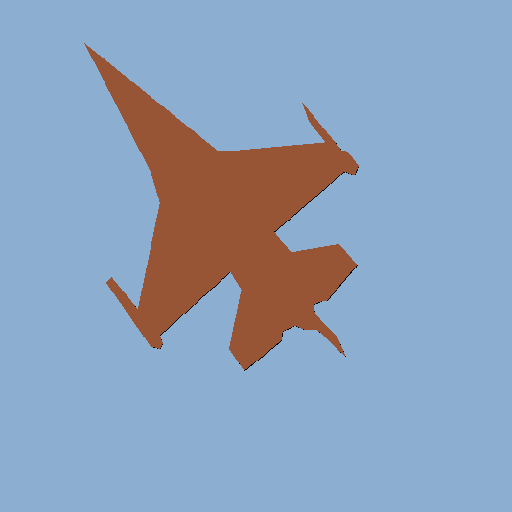

In [4]:
genpath = "/USERSPACE/lukovdg1/controlnet11/checkpoints_vp/v2/checkpoints_coco_global_v2_exp_1/generated_clearshapes.pkl_hardblur_r20_2/outbatches.pkl"
outbatches = pkl.load(open(genpath, "rb"))
segimg = outbatches[0][0].seg_data_src
display(segimg)


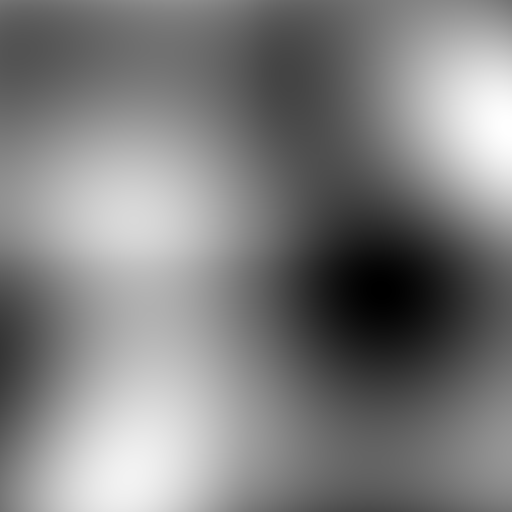

In [291]:
def detect_edges(x):    # x must have as values either 0 or 1 
    up_kernel = torch.tensor([[-1.], [1]]).to(x.device)[None, None]
    down_kernel = torch.tensor([[1.], [-1]]).to(x.device)[None, None]
    left_kernel = torch.tensor([[-1., 1]]).to(x.device)[None, None]
    right_kernel = torch.tensor([[1., -1]]).to(x.device)[None, None]
    up_edges = conv2d(x, up_kernel, padding=1)[:, :, :-1, 1:-1] > 0
    down_edges = conv2d(x, down_kernel, padding=1)[:, :, 1:, 1:-1] > 0
    left_edges = conv2d(x, left_kernel, padding=1)[:, :, 1:-1, :-1] > 0
    right_edges = conv2d(x, right_kernel, padding=1)[:, :, 1:-1, 1:] > 0
    edges = up_edges | down_edges | left_edges | right_edges
    return edges

def generate_random_rmap(shape=(512,512), gridsize=2):
    start = time.time()
    noise = perlin_noise(grid_shape=(gridsize, gridsize), out_shape=shape)
    end = time.time()
    noise = (noise - noise.min()) / (noise.max() - noise.min())
    return noise


display(to_pil_image(generate_random_rmap()))

In [6]:
MAX_RADIUS=32

In [159]:
def create_kernel(radius=5):
    kernel = torch.zeros(1, 1, radius * 2 + 1, radius * 2 + 1)
    for i in range(kernel.shape[2]):
        for j in range(kernel.shape[3]):
            x, y = i - radius, j - radius
            if math.sqrt(x**2 + y**2) <= radius:
                kernel[:, :, i, j] = 1
    return kernel

In [241]:
def variable_hardblur(pilimg, 
                      rmap=5, 
                      perlin_gridsize=2, 
                      colors=None, 
                      bgr_color=torch.tensor([0, 0, 0]), 
                      device=torch.device("cpu"),
                     ):
    # img = to_tensor(pilimg)
    rmap = rmap.to(device)
    img = pilimg.to(device)
    intimg = (img * 255).to(torch.long)
    colorcodes = intimg[2] * 256*256 + intimg[1] * 256 + intimg[0]
    bgrcode = (bgr_color * 255).to(torch.long)
    bgrcode = bgrcode[0] + bgrcode[1] * 256 + bgrcode[2] * 256*256
    uniquecolorcodes = set(colorcodes.unique().cpu().numpy()) - {bgrcode.cpu().item()}
    if colors is None:
        colors = uniquecolorcodes
    
    # create uniform circular kernel
    # radius = MAX_RADIUS
    # kernel = create_kernel(radius).to(device)
    
    # generate separate masks for every color
    regionmasks = []
    for colorcode in colors:
        current_region_mask = (colorcodes == colorcode).float()                                # (H x W)
        kernelsizes = rmap * current_region_mask                                               # (H x W)
        for kernelsize in list(kernelsizes.unique().long().cpu().numpy()):
            if kernelsize < 1:
                continue
            kernelsize_mask = kernelsizes == kernelsize
            # print(kernelsize)
            # display(to_pil_image(kernelsize_mask.float()))
            kernel = create_kernel(kernelsize).to(device)
            expanded_region_mask = (conv2d(kernelsize_mask[None].float(), kernel, padding="same") > 0)
            current_region_mask = torch.maximum(current_region_mask, expanded_region_mask)
        """
        current_kernel_size = 2 ** (torch.log(torch.tensor(kernelsizes.max())) / math.log(2)).floor().cpu()
        print(current_kernel_size)
        display(to_pil_image(kernelsizes / kernelsizes.max()))
        # iterate over kernelsizes from large powers of two to smaller ones and expand image
        while kernelsizes.max().cpu() > 0:
            kernel = create_kernel(current_kernel_size.long().cpu()).to(device)
            current_kernel_mask = kernelsizes >= current_kernel_size
            display(to_pil_image(current_kernel_mask.float()))
            expanded_kernel_mask = (conv2d(current_kernel_mask[None], kernel, padding="same") > 0).float()
            kernelsizes = kernelsizes - current_kernel_size * current_kernel_mask
        regionmask = (conv2d(regionmask[None], kernel, padding="same") > 0).float()
           """ 
        
        #print(current_region_mask)
        #display(to_pil_image(current_region_mask / current_region_mask.max()))
        regionmasks.append(current_region_mask)
        
    # merge masks into overlapping colors
    normalizer = sum(regionmasks)
    ret = torch.zeros_like(img).to(device)
    
    for colorcode, colorimg in zip(colors, regionmasks):
        rgb_tensor = torch.tensor([colorcode % 256, (colorcode // 256) % 256, colorcode // (256*256) ]).to(device)
        ret += colorimg * rgb_tensor[:, None, None]
    ret /= normalizer
    
    ret = torch.where(normalizer > 0, ret, img)
    ret /= 255
    
    return ret

In [301]:
def variable_hardblur_edges(pilimg, 
                      rmap=5, 
                      perlin_gridsize=2, 
                      colors=None, 
                      bgr_color=torch.tensor([0, 0, 0]), 
                      device=torch.device("cpu"),
                     ):
    # img = to_tensor(pilimg)
    rmap = rmap.to(device)
    img = pilimg.to(device)
    intimg = (img * 255).to(torch.long)
    colorcodes = intimg[2] * 256*256 + intimg[1] * 256 + intimg[0]
    bgrcode = (bgr_color * 255).to(torch.long)
    bgrcode = bgrcode[0] + bgrcode[1] * 256 + bgrcode[2] * 256*256
    uniquecolorcodes = set(colorcodes.unique().cpu().numpy()) - {bgrcode.cpu().item()}
    if colors is None:
        colors = uniquecolorcodes
    
    # create uniform circular kernel
    radius = MAX_RADIUS
    kernel = create_kernel(32).to(device)
    
    # generate separate masks for every color
    regionmasks = []
    for colorcode in colors:
        current_region_mask = (colorcodes == colorcode).float()                                # (H x W)
        current_region_edges = detect_edges(current_region_mask[None, None])[0, 0].float()
        current_region_edges_coord = current_region_edges.nonzero().cpu().numpy()
        i = 0
        for i in range(len(current_region_edges_coord)):
            edge_x, edge_y = current_region_edges_coord[i]
            thickness = rmap[edge_x, edge_y]
            brush = interpolate(kernel, (thickness, thickness))
            
        for edge_x, edge_y in current_region_edges.nonzero()
        display(to_pil_image(current_region_edges))
        kernelsizes = rmap * current_region_mask                                               # (H x W)
        for kernelsize in list(kernelsizes.unique().long().cpu().numpy()):
            if kernelsize < 1:
                continue
            kernelsize_mask = kernelsizes == kernelsize
            # print(kernelsize)
            # display(to_pil_image(kernelsize_mask.float()))
            kernel = create_kernel(kernelsize).to(device)
            expanded_region_mask = (conv2d(kernelsize_mask[None].float(), kernel, padding="same") > 0)
            current_region_mask = torch.maximum(current_region_mask, expanded_region_mask)
            
        regionmasks.append(current_region_mask)
        
    # merge masks into overlapping colors
    normalizer = sum(regionmasks)
    ret = torch.zeros_like(img).to(device)
    
    for colorcode, colorimg in zip(colors, regionmasks):
        rgb_tensor = torch.tensor([colorcode % 256, (colorcode // 256) % 256, colorcode // (256*256) ]).to(device)
        ret += colorimg * rgb_tensor[:, None, None]
    ret /= normalizer
    
    ret = torch.where(normalizer > 0, ret, img)
    ret /= 255
    
    return ret

0.5848467350006104


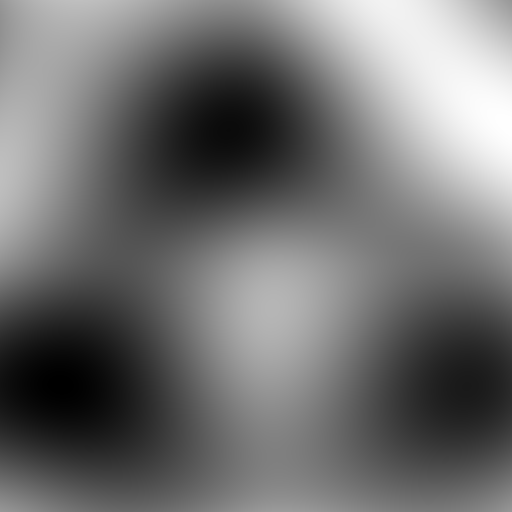

tensor([[ 43,  84],
        [ 44,  85],
        [ 45,  85],
        ...,
        [368, 245],
        [368, 246],
        [369, 244]], device='cuda:0')


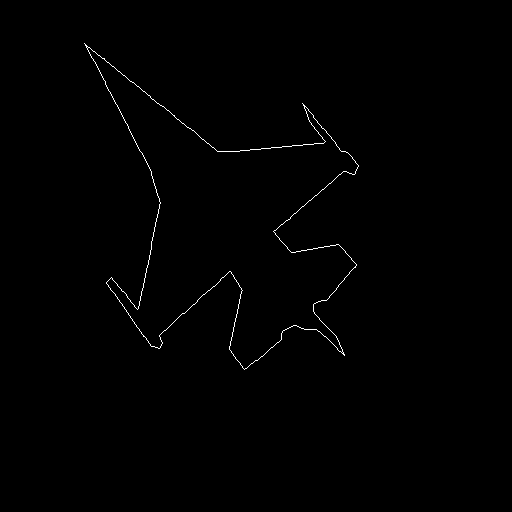

tensor([[  0,   0],
        [  0,   1],
        [  0,   2],
        ...,
        [511, 509],
        [511, 510],
        [511, 511]], device='cuda:0')


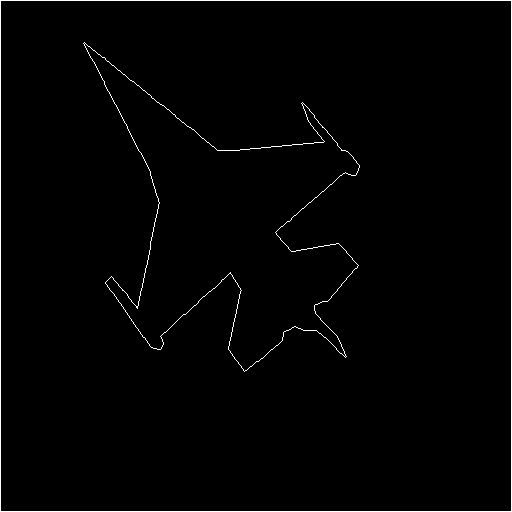

0.8909518718719482


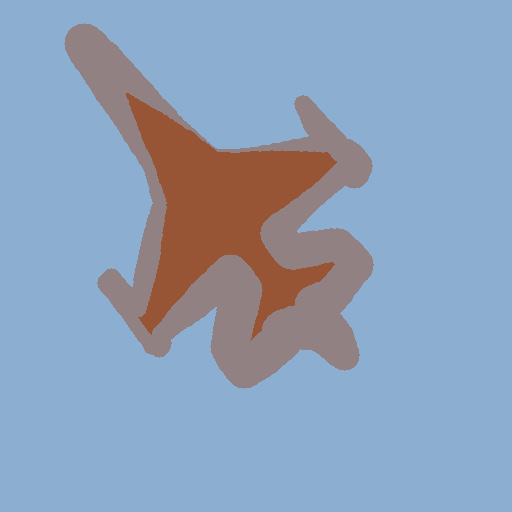

In [303]:
start = time.time()
_rmap = generate_random_rmap(gridsize=2)
rmap = (_rmap * MAX_RADIUS).long()
end = time.time()
print(end - start)
display(to_pil_image(_rmap))

end = time.time()
ret = variable_hardblur_edges(  (pil_to_tensor(segimg) / 255).float() , rmap=rmap)
end2 = time.time()
print(end2 - end)
display(to_pil_image(ret))

In [ ]:
start = time.time()
_rmap = generate_random_rmap(gridsize=2)
rmap = (_rmap * MAX_RADIUS).long()
end = time.time()
print(end - start)
display(to_pil_image(_rmap))

end = time.time()
ret = variable_hardblur_edges(  (pil_to_tensor(segimg) / 255).float() , rmap=rmap , device=torch.device("cuda", 0)  )
end2 = time.time()
print(end2 - end)
display(to_pil_image(ret))

In [9]:
2 ** (torch.log(torch.tensor(31))/ math.log(2)).floor()

tensor(16.)

In [131]:
x = torch.arange(0, 512, device=torch.device("cuda", 0))
data = torch.randn(512, device=torch.device("cuda", 0))
SIZE = 1

In [136]:
out = torch.zeros_like(data)
start = time.time()
for i in range(SIZE, x.shape[0]-SIZE):
    out[i] = data[i-SIZE:i+SIZE+1].sum()
    # out[i] = torch.cos(data[i].mean())
end = time.time()
print(end - start)
y_ref = copy.deepcopy(out)

0.015477895736694336


In [139]:
_x = (torch.arange(0, 512)[:, None]  + torch.arange(0, 3)[None] - 1)[1:-1]
print(_x.shape)
print(_x[:5])
print(data[:20])

def func(i, d):
    return d[i].sum()

func_vmapped = torch.vmap(func, in_dims=(0, None))
            
start = time.time()
y = func_vmapped(_x, data)
end = time.time()
print(end - start)
print(torch.allclose(y, y_ref[1:-1]))
print(y[:20])
print(y_ref[:20])

torch.Size([510, 3])
tensor([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])
tensor([-0.6743,  0.9574, -0.6625,  1.2584,  0.9288, -0.3673, -1.1449, -1.6543,
        -0.6504,  1.1037,  0.0767, -0.7576,  0.4516, -0.0443, -0.0213,  0.2813,
        -1.3237, -0.2768, -0.3113, -0.5652], device='cuda:0')
0.0018625259399414062
True
tensor([-0.3795,  1.5532,  1.5246,  1.8199, -0.5833, -3.1665, -3.4496, -1.2010,
         0.5299,  0.4227, -0.2293, -0.3502,  0.3860,  0.2157, -1.0637, -1.3192,
        -1.9119, -1.1534, -0.5107,  0.3757], device='cuda:0')
tensor([ 0.0000, -0.3795,  1.5532,  1.5246,  1.8199, -0.5833, -3.1665, -3.4496,
        -1.2010,  0.5299,  0.4227, -0.2293, -0.3502,  0.3860,  0.2157, -1.0637,
        -1.3192, -1.9119, -1.1534, -0.5107], device='cuda:0')


In [135]:
sum([-0.6743,  0.9574, -0.6625])

-0.37939999999999996

In [155]:
a = torch.randn(512+16, 512+16).to(torch.device("cuda", 1))
patches = kornia.contrib.extract_tensor_patches(a[None, None], (32, 32))[0, :, 0]
print(patches.shape)
del(patches)

torch.Size([247009, 32, 32])


In [150]:
print(a)
print(patches[0])

tensor([[ 1.4494e+00, -6.2760e-01,  1.0111e+00,  2.5337e-01,  1.1889e+00,
          8.0706e-01,  1.8225e+00, -1.8437e-02, -9.1426e-01, -9.3698e-01],
        [ 1.5982e+00,  5.8179e-03, -7.8502e-01, -4.0751e-01,  1.0706e+00,
         -5.7333e-01, -4.4712e-01,  1.7052e-01, -2.4029e-01,  7.6882e-01],
        [-3.0841e-01, -5.7014e-01, -8.8298e-02, -1.1384e+00, -1.8282e-01,
         -3.2198e-01,  1.9483e+00, -1.8248e-01,  1.3446e+00,  1.4114e+00],
        [ 1.1500e+00, -1.8274e-01, -1.8171e+00, -1.7266e+00, -3.8848e-01,
         -3.1148e-01, -1.2635e+00, -1.8886e+00, -8.3621e-01,  8.3461e-01],
        [ 4.2452e-01, -2.1436e-01, -7.6110e-01,  4.9263e-01, -1.7475e+00,
         -5.9932e-01,  7.3605e-01,  3.5699e-01, -9.6857e-01,  9.2928e-01],
        [-7.6201e-01,  7.6729e-01, -8.7052e-01,  1.2635e+00,  9.6890e-01,
          2.4886e-01,  1.0457e-01,  1.8559e-01, -8.9850e-01,  1.0145e-01],
        [ 6.3460e-01, -2.9845e-02, -9.5877e-01,  3.6154e-01, -6.3633e-01,
          3.8850e-01, -5.1959e-0

In [52]:
a = torch.randn(5, 5)
def f(_a):
    return torch.cos(_a)

f_vmapped = torch.vmap(torch.vmap(f, in_dims=(0,)), in_dims=(1,))
print(a)
print(f_vmapped(a))

tensor([[-0.7684,  2.2274, -1.3644, -1.1218,  0.8443],
        [-2.3374,  0.2924, -0.8414,  0.0621,  0.6875],
        [ 0.4621, -0.7638,  1.0374,  1.4470, -0.9618],
        [ 0.1153, -1.2412,  0.4648,  0.3400, -0.6512],
        [-1.2717, -0.5997, -2.7113, -0.2885,  0.3493]])
tensor([[ 0.7191, -0.6937,  0.8951,  0.9934,  0.2946],
        [-0.6105,  0.9575,  0.7222,  0.3236,  0.8255],
        [ 0.2049,  0.6664,  0.5084,  0.8939, -0.9088],
        [ 0.4341,  0.9981,  0.1235,  0.9428,  0.9587],
        [ 0.6642,  0.7728,  0.5721,  0.7954,  0.9396]])


In [197]:
k = create_kernel(5)
print(k.long())

tensor([[[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
          [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]]])


In [290]:
print(detect_edges(k).long())

tensor([[[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]]])


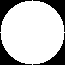

tensor([[[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
          [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [0, 1, 1, 1, 1, 1, 1, 1,

In [289]:
kernel = create_kernel(32)
display(to_pil_image(kernel[0]))
interp = interpolate(kernel, (19, 19), mode="bilinear")
display(to_pil_image(interp[0]))
print((interp > 0).long())
